In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
!git clone https://github.com/time-series-foundation-models/lag-llama/ 

fatal: destination path 'lag-llama' already exists and is not an empty directory.


In [3]:
cd lag-llama 

/Users/anthonybolton/Developer/FYP/ts-fm-benchmark-financial/benchmarks/lag-llama


In [4]:
pip install -r requirements.txt --quiet 

Note: you may need to restart the kernel to use updated packages.


In [5]:
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir weights/

weights/lag-llama.ckpt


# Test model on S&P500 from documentation Colab demo examples

### official Colab demo for zero-shot forecasting: https://colab.research.google.com/drive/1DRAzLUPxsd-0r8b-o4nlyFXrjw_ZajJJ?authuser=1#scrollTo=Mj9LXMpJ01d7&line=6&uniqifier=1 
### random medium blog: https://medium.com/@odhitom09/lag-llama-an-open-source-base-model-for-predicting-time-series-data-2e897fddf005

/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_60207/2040790817.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", 

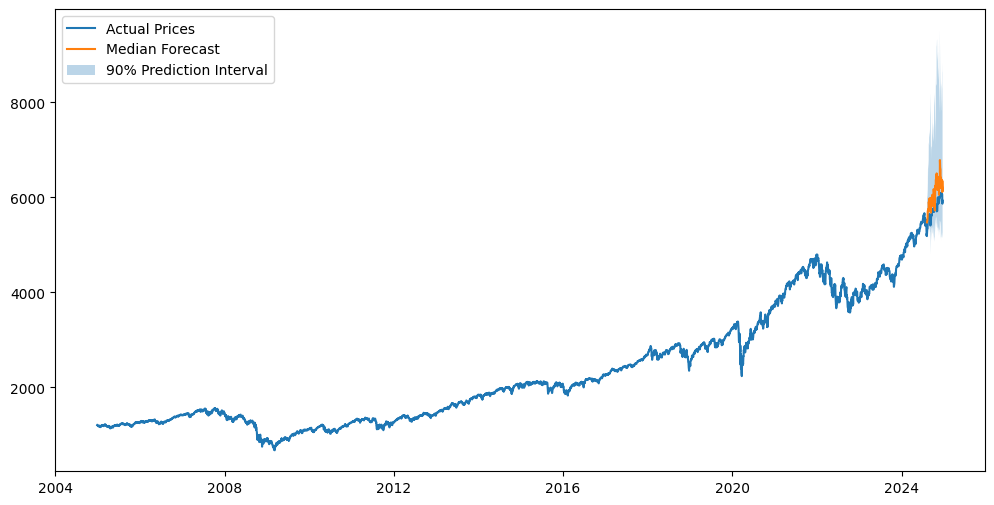

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import make_evaluation_predictions
from lag_llama.gluon.estimator import LagLlamaEstimator

from data.snp500 import snp500_daily

# Prepare the data
sp500_d = snp500_daily.reset_index()[["Date", "Close"]]
sp500_d["Date"] = pd.to_datetime(sp500_d["Date"])

# Create the GluonTS dataset
# Flatten the 'Close' values to ensure a 1D target array
dataset = ListDataset(
    [{"start": sp500_d["Date"].iloc[0], "target": sp500_d["Close"].values.flatten()}],
    freq="D"
)


# Define lengths
prediction_length = 96
context_length = 3 * prediction_length

# Load the checkpoint
ckpt = torch.load("weights/lag-llama.ckpt", map_location=torch.device("mps" if torch.backends.mps.is_available() else "cpu"))
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

# Initialize the model
estimator = LagLlamaEstimator(
    ckpt_path="weights/lag-llama.ckpt",
    prediction_length=prediction_length,
    context_length=context_length,
    input_size=estimator_args["input_size"],
    n_layer=estimator_args["n_layer"],
    n_embd_per_head=estimator_args["n_embd_per_head"],
    n_head=estimator_args["n_head"],
    scaling=estimator_args["scaling"],
    time_feat=estimator_args["time_feat"],
    device=torch.device("mps" if torch.cuda.is_available() else "cpu")
)

# Create predictor
lightning_module = estimator.create_lightning_module()
transformation = estimator.create_transformation()
predictor = estimator.create_predictor(transformation, lightning_module)

# Generate predictions
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset,
    predictor=predictor,
    num_samples=100
)

forecasts = list(forecast_it)
tss = list(ts_it)

# Extract forecast samples
forecast_samples = forecasts[0].samples
low, median, high = np.percentile(forecast_samples, [10, 50, 90], axis=0)

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(sp500_d["Date"], sp500_d["Close"], label="Actual Prices")
plt.plot(sp500_d["Date"][-prediction_length:], median, label="Median Forecast")
plt.fill_between(sp500_d["Date"][-prediction_length:], low, high, alpha=0.3, label="90% Prediction Interval")
plt.legend()
plt.show()


# Testing the model: context 720 prediction 96

/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_60207/3907734629.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", 


Full Period Metrics:
MAE: 260.2923
MSE: 105043.2192
RMSE: 324.1037
MAPE: 4.4881
SMAPE: 4.4343
MASE: 7.2383


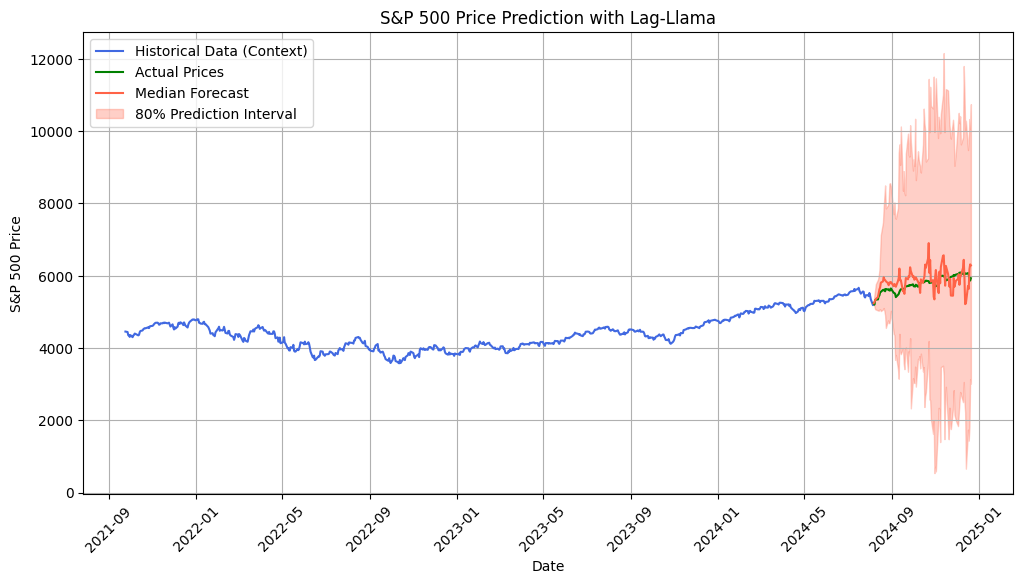

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import make_evaluation_predictions
from lag_llama.gluon.estimator import LagLlamaEstimator

from data.snp500 import snp500_daily
from utils.metrics import metric

CONTEXT_WINDOW = 720
PREDICTION_WINDOW = 96

def get_lag_llama_predictions(dataset, prediction_length, context_length=32, use_rope_scaling=False, num_samples=100):
    ckpt = torch.load("weights/lag-llama.ckpt", map_location=torch.device("mps" if torch.cuda.is_available() else "cpu")
)
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]
    
    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    }
    
    estimator = LagLlamaEstimator(
        ckpt_path="weights/lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling=rope_scaling_arguments if use_rope_scaling else None,
        device=torch.device("mps" if torch.cuda.is_available() else "cpu")
    )
    
    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)
    
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)
    
    return forecasts, tss

def generate_forecast(context_data, dates):
    """Generate and process forecast using Lag-Llama"""
    # Ensure data is 1D and dates are correct
    context = np.asarray(context_data).flatten()
    start_date = dates.iloc[0]  # Get first date from dates Series

    # Create ListDataset
    dataset = ListDataset(
        [{"start": start_date, "target": context}],
        freq="D"
    )
    
    # Get device
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    # Generate forecast
    forecasts, _ = get_lag_llama_predictions(
        dataset=dataset,
        prediction_length=PREDICTION_WINDOW,
        context_length=CONTEXT_WINDOW,
        use_rope_scaling=True,
        num_samples=100
    )
    forecast_samples = forecasts[0].samples

    # Extract quantiles
    low, median, high = np.percentile(forecast_samples, [10, 50, 90], axis=0)
    return low, median, high

def calculate_metrics(actual, predicted, insample=None):
    """Calculate all metrics using the metrics.py implementations"""
    actual = np.array(actual).flatten()
    predicted = np.array(predicted).flatten()

    # Calculate basic metrics
    mae, mse, rmse, mape, mspe = metric(predicted, actual)

    # Calculate SMAPE
    smape = 200 * np.mean(
        np.abs(predicted - actual) / (np.abs(predicted) + np.abs(actual))
    )

    # Calculate MASE
    if insample is not None:
        naive_forecast = insample[:-1]
        naive_target = insample[1:]
        naive_mae = np.mean(np.abs(naive_target - naive_forecast))
        mase = mae / naive_mae if naive_mae != 0 else np.nan
    else:
        mase = np.nan

    metrics = {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "MAPE": mape * 100,
        "SMAPE": smape,
        "MASE": mase if not np.isnan(mase) else None,
    }

    return metrics

def plot_forecast(
    data,
    context_window,
    prediction_window,
    median_forecast,
    low_forecast,
    high_forecast,
    title,
):
    """Create visualization with zoomed context"""
    plt.figure(figsize=(12, 6))

    # Get the last point of historical context
    last_context_point = data["Close"].iloc[-prediction_window - 1]

    # Add last context point to forecasts for continuity
    median_forecast = np.insert(median_forecast, 0, last_context_point)
    low_forecast = np.insert(low_forecast, 0, last_context_point)
    high_forecast = np.insert(high_forecast, 0, last_context_point)

    # Create forecast dates
    forecast_dates = pd.concat(
        [
            data["Date"].iloc[-(prediction_window + 1) : -prediction_window],
            data["Date"].iloc[-prediction_window:],
        ]
    )

    # Get actual prices including last context point
    actual_prices = data["Close"].iloc[-prediction_window:].values
    actual_prices = np.insert(actual_prices, 0, last_context_point)

    # Plot historical context
    plt.plot(
        data["Date"].iloc[-(context_window + prediction_window) : -prediction_window],
        data["Close"].iloc[-(context_window + prediction_window) : -prediction_window],
        color="royalblue",
        label="Historical Data (Context)",
    )

    # Plot actual prices
    plt.plot(forecast_dates, actual_prices, color="green", label="Actual Prices")

    # Plot forecast
    plt.plot(forecast_dates, median_forecast, color="tomato", label="Median Forecast")
    plt.fill_between(
        forecast_dates,
        low_forecast,
        high_forecast,
        color="tomato",
        alpha=0.3,
        label="80% Prediction Interval",
    )

    plt.xlabel("Date")
    plt.ylabel("S&P 500 Price")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    plt.show()

# Prepare the data
sp500_d = snp500_daily.reset_index()[["Date", "Close"]]
sp500_d["Date"] = pd.to_datetime(sp500_d["Date"])

# Generate full period forecast
context = sp500_d["Close"].values[-CONTEXT_WINDOW:]
context_dates = sp500_d["Date"].iloc[-CONTEXT_WINDOW:]  # This is now a pandas Series
low, median, high = generate_forecast(context, context_dates)

# Calculate and print metrics for full period
actual_prices = sp500_d["Close"].values[-PREDICTION_WINDOW:]
insample_data = sp500_d["Close"].values[
    -CONTEXT_WINDOW - PREDICTION_WINDOW : -PREDICTION_WINDOW
]
metrics = calculate_metrics(actual_prices, median, insample=insample_data)

print("\nFull Period Metrics:")
for metric_name, value in metrics.items():
    if value is not None:
        print(f"{metric_name}: {value:.4f}")
    else:
        print(f"{metric_name}: N/A")

# Plot full period forecast
plot_forecast(
    sp500_d,
    CONTEXT_WINDOW,
    PREDICTION_WINDOW,
    median,
    low,
    high,
    "S&P 500 Price Prediction with Lag-Llama"
)

# COVID-19 recovery

/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_60207/3907734629.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", 


COVID Period Metrics:
MAE: 945.3959
MSE: 923046.9130
RMSE: 960.7533
MAPE: 20.6858
SMAPE: 23.1447
MASE: 26.8703


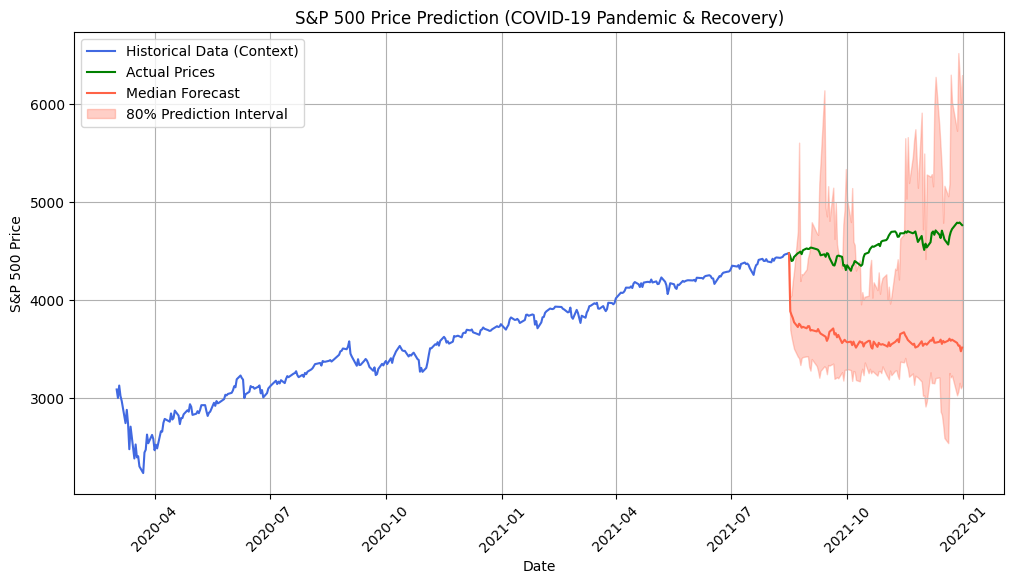

In [26]:
# COVID-19 Period Analysis
covid_start_date = "2020-03-01"
covid_end_date = "2021-12-31"

# Filter COVID period data
covid_data = sp500_d[
    (sp500_d["Date"] >= covid_start_date) & (sp500_d["Date"] <= covid_end_date)
].reset_index(drop=True)

# Generate COVID period forecast
covid_context = (
    covid_data["Close"]
    .iloc[-(CONTEXT_WINDOW + PREDICTION_WINDOW) : -PREDICTION_WINDOW]
    .values
)

# Get corresponding dates for the context period
covid_context_dates = covid_data["Date"].iloc[
    -(CONTEXT_WINDOW + PREDICTION_WINDOW) : -PREDICTION_WINDOW
]

# Generate forecast for the COVID period
low_covid, median_covid, high_covid = generate_forecast(covid_context, covid_context_dates)

# Calculate and print COVID period metrics
actual_prices_covid = covid_data["Close"].iloc[-PREDICTION_WINDOW:].values
insample_data_covid = (
    covid_data["Close"]
    .iloc[-CONTEXT_WINDOW - PREDICTION_WINDOW : -PREDICTION_WINDOW]
    .values
)
metrics_covid = calculate_metrics(
    actual_prices_covid, median_covid, insample=insample_data_covid
)

print("\nCOVID Period Metrics:")
for metric_name, value in metrics_covid.items():
    if value is not None:
        print(f"{metric_name}: {value:.4f}")
    else:
        print(f"{metric_name}: N/A")

# Plot COVID period forecast
plot_forecast(
    covid_data,
    CONTEXT_WINDOW,
    PREDICTION_WINDOW,
    median_covid,
    low_covid,
    high_covid,
    "S&P 500 Price Prediction (COVID-19 Pandemic & Recovery)",
)


# Experimenting with different context and prediction windows for different frequencies: daily, weekly, monthly. Note that for lag-llama conetxt window must be > prediction window


Running daily frequency experiments...


/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_60875/3924528634.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", 

Skipping invalid combination: context_window=96, prediction_window=192
Skipping invalid combination: context_window=96, prediction_window=336
Skipping invalid combination: context_window=96, prediction_window=720


/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_60875/3924528634.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", 

Skipping invalid combination: context_window=192, prediction_window=336
Skipping invalid combination: context_window=192, prediction_window=720


/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_60875/3924528634.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", 

Skipping invalid combination: context_window=336, prediction_window=720


/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_60875/3924528634.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", 

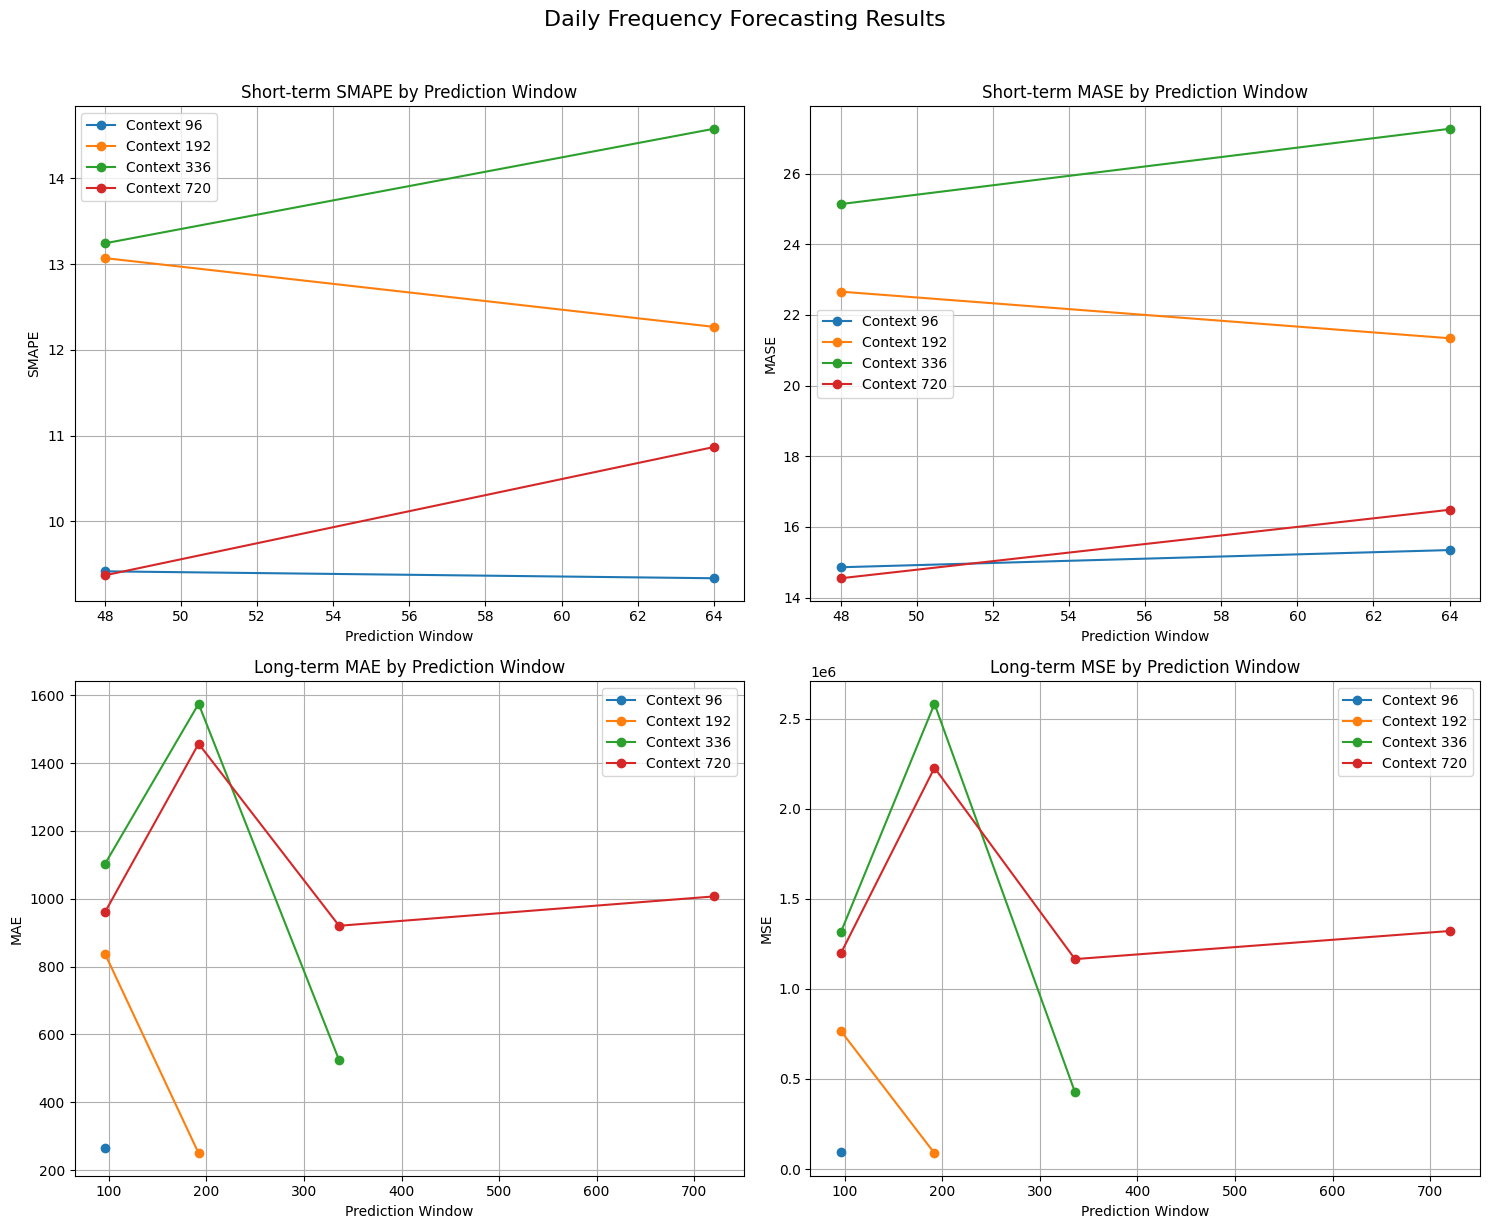


Daily Frequency Results:

Short-term Forecasting Results:
Metric                                 MAE     MAPE     MASE          MSE  \
Context Window Prediction Window                                            
96             48                 534.1976   8.9827  14.8591  294581.6174   
               64                 526.2075   8.8990  15.3455  293857.1755   
192            48                 728.3981  12.2428  22.6608  551564.8210   
               64                 680.8361  11.5022  21.3418  507184.3786   
336            48                 737.1031  12.3854  25.1398  570883.6465   
               64                 798.1068  13.4768  27.2704  717679.4010   
720            48                 530.9030   8.9019  14.5477  318595.4532   
               64                 603.4977  10.1520  16.4861  473847.1046   

Metric                                RMSE    SMAPE  
Context Window Prediction Window                     
96             48                 542.7537   9.4177  
        

/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_60875/3924528634.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", 

Skipping invalid combination: context_window=24, prediction_window=48
Skipping invalid combination: context_window=24, prediction_window=64
Skipping invalid combination: context_window=24, prediction_window=96


/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_60875/3924528634.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", 

Skipping invalid combination: context_window=48, prediction_window=64
Skipping invalid combination: context_window=48, prediction_window=96


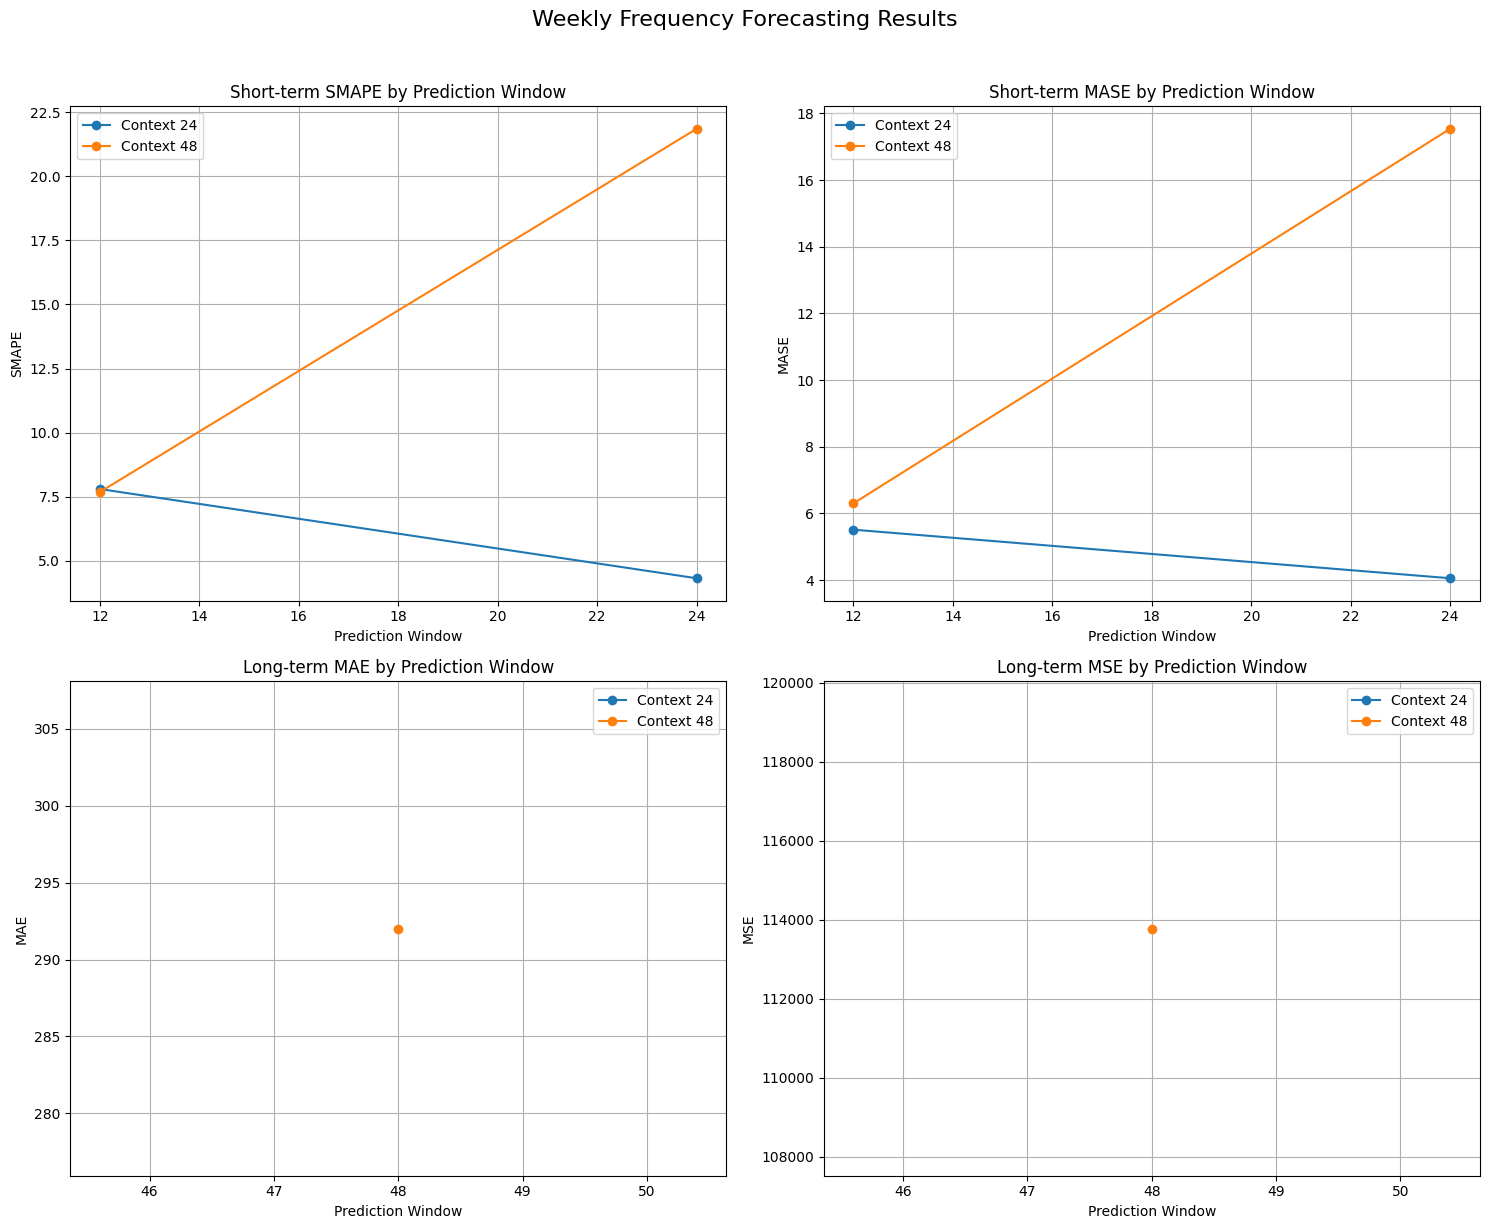


Weekly Frequency Results:

Short-term Forecasting Results:
Metric                                  MAE     MAPE     MASE           MSE  \
Context Window Prediction Window                                              
24             12                  444.6512   7.4820   5.5103  2.175420e+05   
               24                  245.8746   4.2081   4.0532  8.575151e+04   
48             12                  437.8516   7.3554   6.3003  2.239690e+05   
               24                 1131.3938  19.5831  17.5366  1.370134e+06   

Metric                                 RMSE    SMAPE  
Context Window Prediction Window                      
24             12                  466.4140   7.8009  
               24                  292.8336   4.3213  
48             12                  473.2536   7.6835  
               24                 1170.5272  21.8503  

Long-term Forecasting Results:
Metric                                 MAE    MAPE    MASE          MSE  \
Context Window Prediction Wi

/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_60875/3924528634.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", 

Skipping invalid combination: context_window=6, prediction_window=12
Skipping invalid combination: context_window=6, prediction_window=24


/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_60875/3924528634.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", 

Skipping invalid combination: context_window=12, prediction_window=24


/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_60875/3924528634.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", 

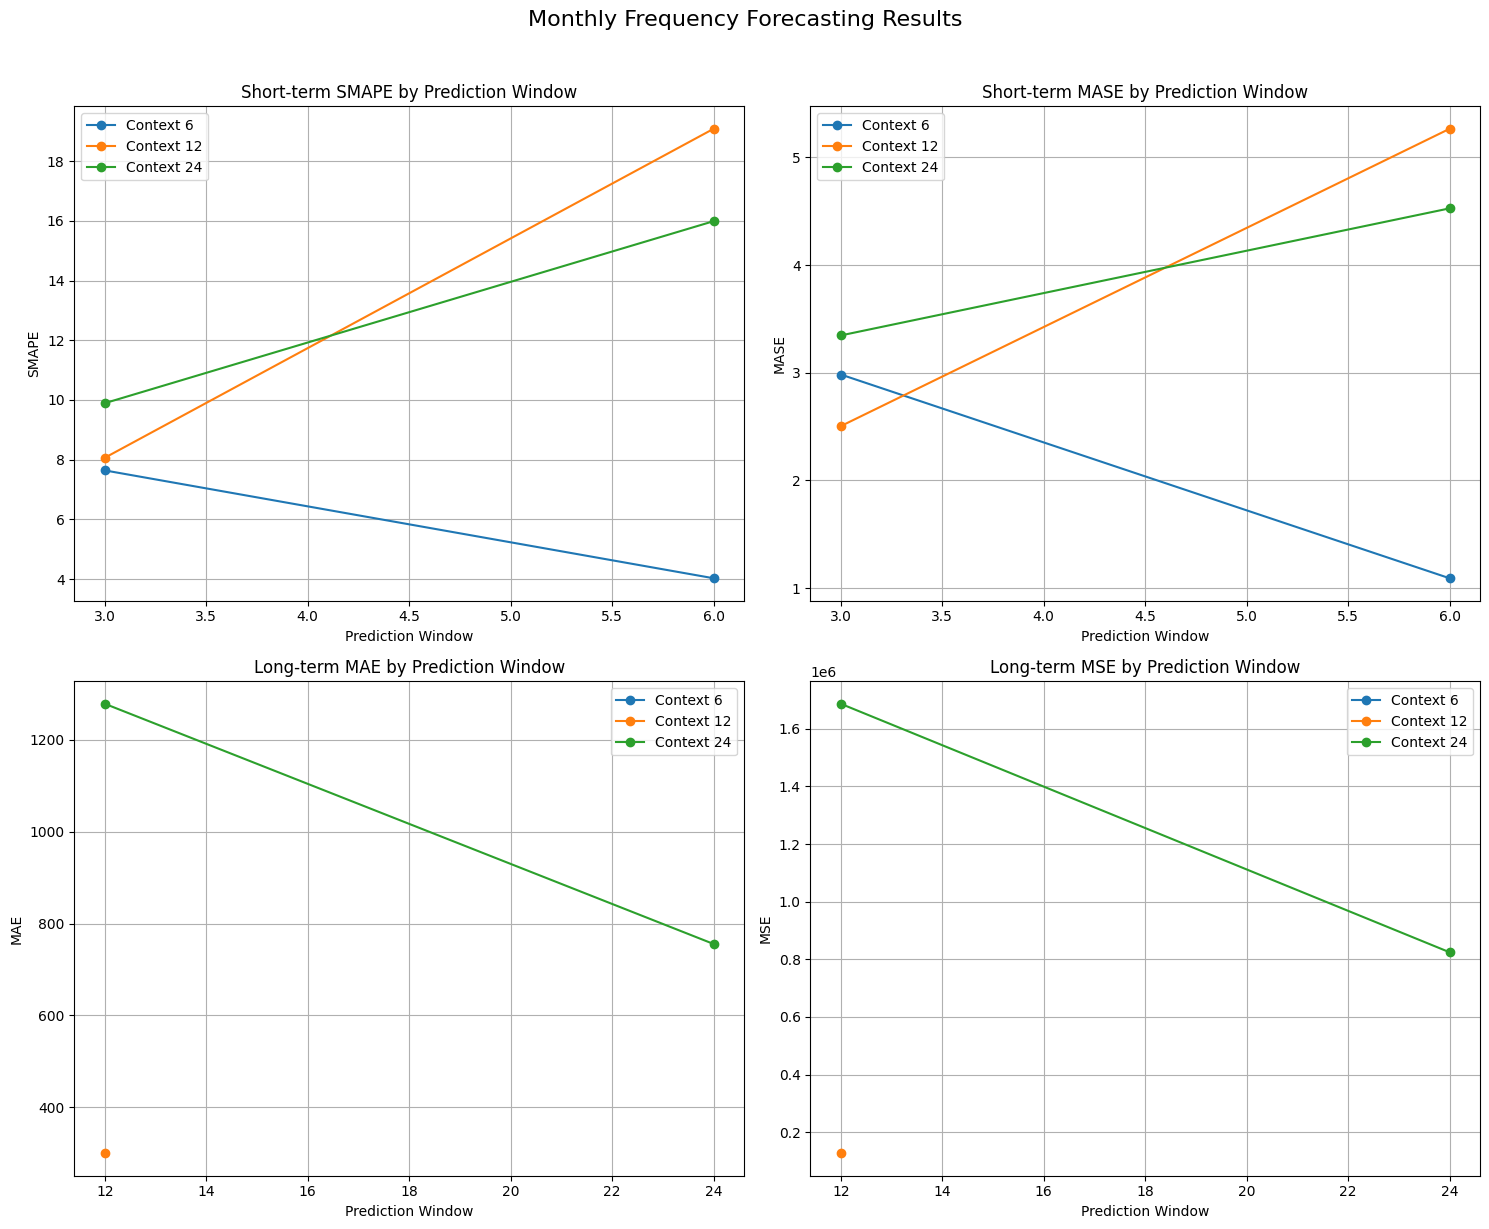


Monthly Frequency Results:

Short-term Forecasting Results:
Metric                                  MAE     MAPE    MASE           MSE  \
Context Window Prediction Window                                             
6              3                   433.6736   7.3346  2.9835  2.068700e+05   
               6                   229.6953   3.9140  1.0916  7.803343e+04   
12             3                   456.7298   7.7241  2.5045  2.300067e+05   
               6                  1004.8255  17.3941  5.2655  1.031934e+06   
24             3                   554.7057   9.3879  3.3466  3.363069e+05   
               6                   854.4048  14.7791  4.5266  7.512259e+05   

Metric                                 RMSE    SMAPE  
Context Window Prediction Window                      
6              3                   454.8296   7.6402  
               6                   279.3446   4.0288  
12             3                   479.5901   8.0649  
               6                  1015.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import make_evaluation_predictions
from lag_llama.gluon.estimator import LagLlamaEstimator

from data.snp500 import snp500_daily, snp500_monthly, snp500_weekly
from utils.evaluate import ContextPredictionWindowEvaluator


def lag_llama_forecast(model, context, prediction_window, freq="D"):
    """Forecast function for Lag-Llama model"""
    # Ensure data is 1D
    context = np.asarray(context).flatten()

    # Validate context length
    if len(context) < prediction_window:
        raise ValueError(
            f"Context length ({len(context)}) is less than the prediction window ({prediction_window})."
        )

    # Create a pandas Series with datetime index
    dates = pd.date_range(end=pd.Timestamp.now(), periods=len(context), freq=freq)
    context_series = pd.Series(context, index=dates)

    # Load the checkpoint
    ckpt = torch.load("weights/lag-llama.ckpt", map_location=torch.device("mps"))
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    # Initialize the model
    estimator = LagLlamaEstimator(
        ckpt_path="weights/lag-llama.ckpt",
        prediction_length=prediction_window,
        context_length=len(context),
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling={
            "type": "linear",
            "factor": max(1.0, (len(context) + prediction_window) / estimator_args["context_length"]),
        },
        device=torch.device("mps"),
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    # Prepare data in GluonTS format
    dataset = ListDataset(
        [{"start": str(dates[0]), "target": context}],
        freq=freq,
    )

    # Generate forecast
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset, predictor=predictor, num_samples=100
    )
    forecasts = list(forecast_it)
    forecast_samples = forecasts[0].samples

    # Extract quantiles and ensure correct length
    low, median, high = np.percentile(forecast_samples, [10, 50, 90], axis=0)

    # Verify lengths match expected prediction window
    assert (
        len(median) == prediction_window
    ), f"Prediction length mismatch: got {len(median)}, expected {prediction_window}"

    return low, median, high

# Plot results by frequency
def plot_results_by_frequency(results_df, frequency):
    """Create plots for short-term and long-term metrics"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(
        f"{frequency.capitalize()} Frequency Forecasting Results", fontsize=16, y=1.02
    )

    # Short-term metrics (SMAPE and MASE)
    short_term = results_df[results_df["Horizon"] == "short_term"]
    context_windows = sorted(short_term["Context Window"].unique())

    # Plot SMAPE
    ax = axes[0, 0]
    for context in context_windows:
        data = short_term[
            (short_term["Context Window"] == context)
            & (short_term["Metric"] == "SMAPE")
        ]
        ax.plot(
            data["Prediction Window"],
            data["Value"],
            marker="o",
            label=f"Context {context}",
        )
    ax.set_xlabel("Prediction Window")
    ax.set_ylabel("SMAPE")
    ax.set_title("Short-term SMAPE by Prediction Window")
    ax.grid(True)
    ax.legend()

    # Plot MASE
    ax = axes[0, 1]
    for context in context_windows:
        data = short_term[
            (short_term["Context Window"] == context) & (short_term["Metric"] == "MASE")
        ]
        ax.plot(
            data["Prediction Window"],
            data["Value"],
            marker="o",
            label=f"Context {context}",
        )
    ax.set_xlabel("Prediction Window")
    ax.set_ylabel("MASE")
    ax.set_title("Short-term MASE by Prediction Window")
    ax.grid(True)
    ax.legend()

    # Long-term metrics (MAE and MSE)
    long_term = results_df[results_df["Horizon"] == "long_term"]

    # Plot MAE
    ax = axes[1, 0]
    for context in context_windows:
        data = long_term[
            (long_term["Context Window"] == context) & (long_term["Metric"] == "MAE")
        ]
        ax.plot(
            data["Prediction Window"],
            data["Value"],
            marker="o",
            label=f"Context {context}",
        )
    ax.set_xlabel("Prediction Window")
    ax.set_ylabel("MAE")
    ax.set_title("Long-term MAE by Prediction Window")
    ax.grid(True)
    ax.legend()

    # Plot MSE
    ax = axes[1, 1]
    for context in context_windows:
        data = long_term[
            (long_term["Context Window"] == context) & (long_term["Metric"] == "MSE")
        ]
        ax.plot(
            data["Prediction Window"],
            data["Value"],
            marker="o",
            label=f"Context {context}",
        )
    ax.set_xlabel("Prediction Window")
    ax.set_ylabel("MSE")
    ax.set_title("Long-term MSE by Prediction Window")
    ax.grid(True)
    ax.legend()

    plt.tight_layout()
    plt.show()

# Initialize experiment runner with dummy model (will be recreated for each prediction)
dummy_model = None  # Model will be created dynamically in lag_llama_forecast

experiments = ContextPredictionWindowEvaluator(
    model=dummy_model, forecast_fn=lag_llama_forecast
)

# Dictionary to store results for each frequency
frequency_results = {}

# Run experiments for each frequency
frequency_results = {}

# Run experiments for each frequency
frequencies = {
    "daily": ("D", snp500_daily),
    "weekly": ("W", snp500_weekly),
    "monthly": ("M", snp500_monthly),
}

for freq_name, (freq, data) in frequencies.items():
    print(f"\nRunning {freq_name} frequency experiments...")

    # Update the forecast function to include frequency
    experiments.forecast_fn = lambda model, context, pred_window: lag_llama_forecast(
        model, context, pred_window, freq=freq
    )

    # Run experiments
    results = experiments.run_frequency_experiments_context_cannot_be_snaller_than_prediction(data, freq_name)
    frequency_results[freq_name] = results

    # Format results
    df_results = experiments.format_results(results)

    # Create visualizations
    plot_results_by_frequency(df_results, freq_name)

    # Create separate DataFrames for short-term and long-term results
    short_term_df = (
        df_results[df_results["Horizon"] == "short_term"]
        .pivot_table(
            index=["Context Window", "Prediction Window"],
            columns="Metric",
            values="Value",
        )
        .round(4)
    )

    long_term_df = (
        df_results[df_results["Horizon"] == "long_term"]
        .pivot_table(
            index=["Context Window", "Prediction Window"],
            columns="Metric",
            values="Value",
        )
        .round(4)
    )

    print(f"\n{freq_name.capitalize()} Frequency Results:")
    print("\nShort-term Forecasting Results:")
    print(short_term_df)
    print("\nLong-term Forecasting Results:")
    print(long_term_df)



# Forecasting visuals and metric results of best performing runs for recent and COVID-19 periods

Generating plots for extended period...


/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_60875/1019413267.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", 

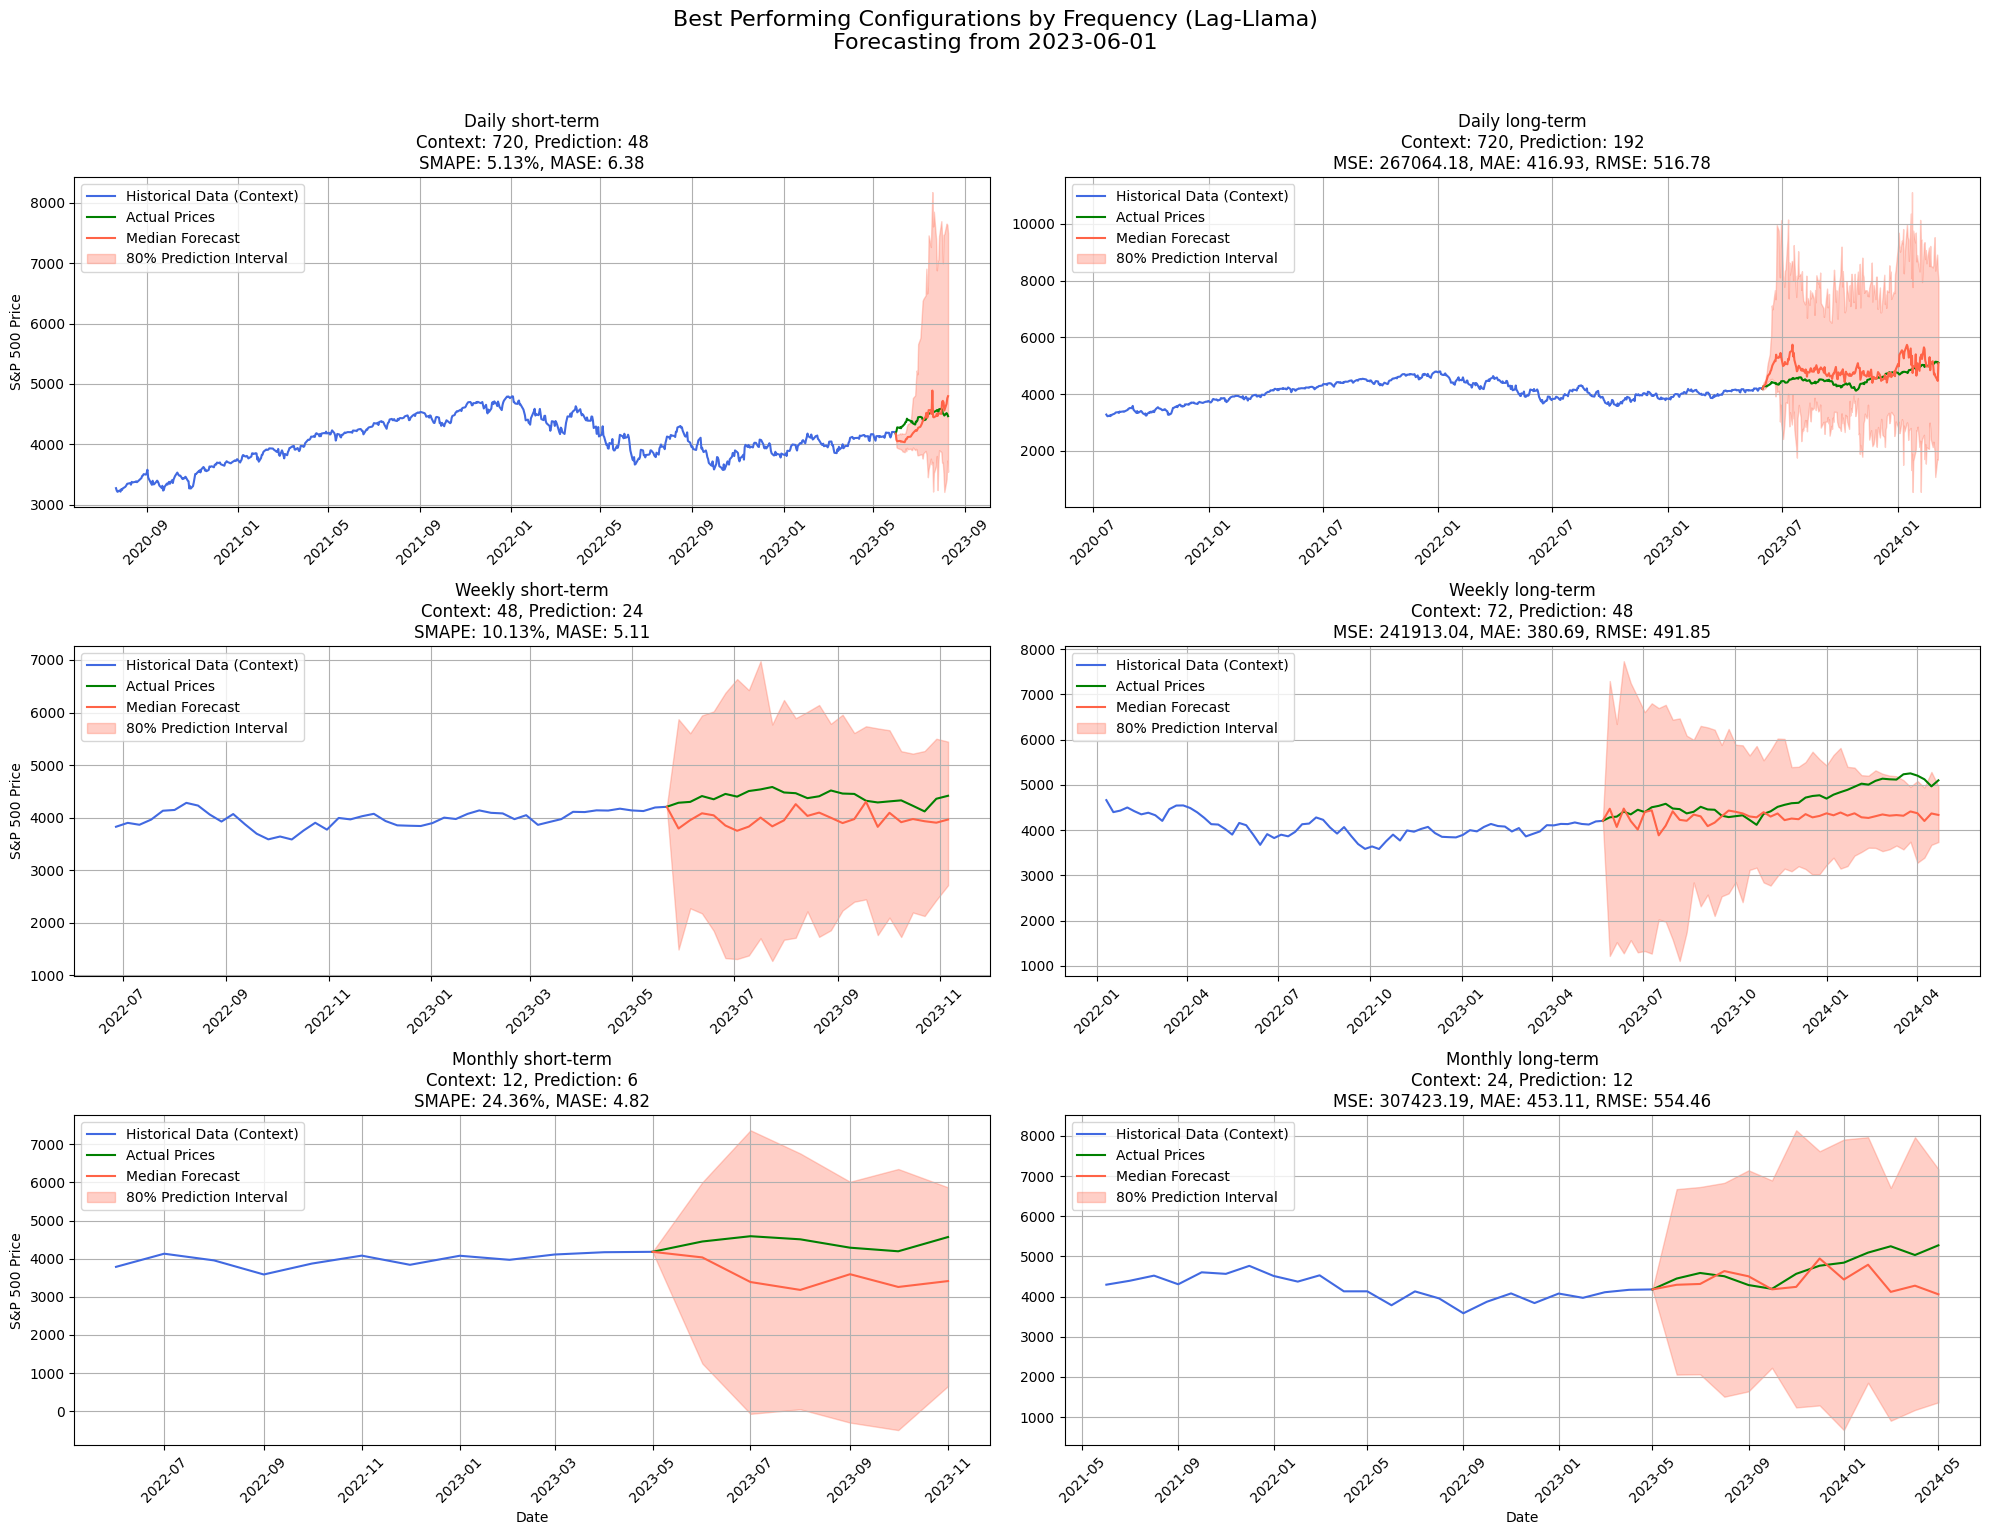


Generating plots for COVID period...


/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/ipykernel_60875/1019413267.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("weights/lag-llama.ckpt", 

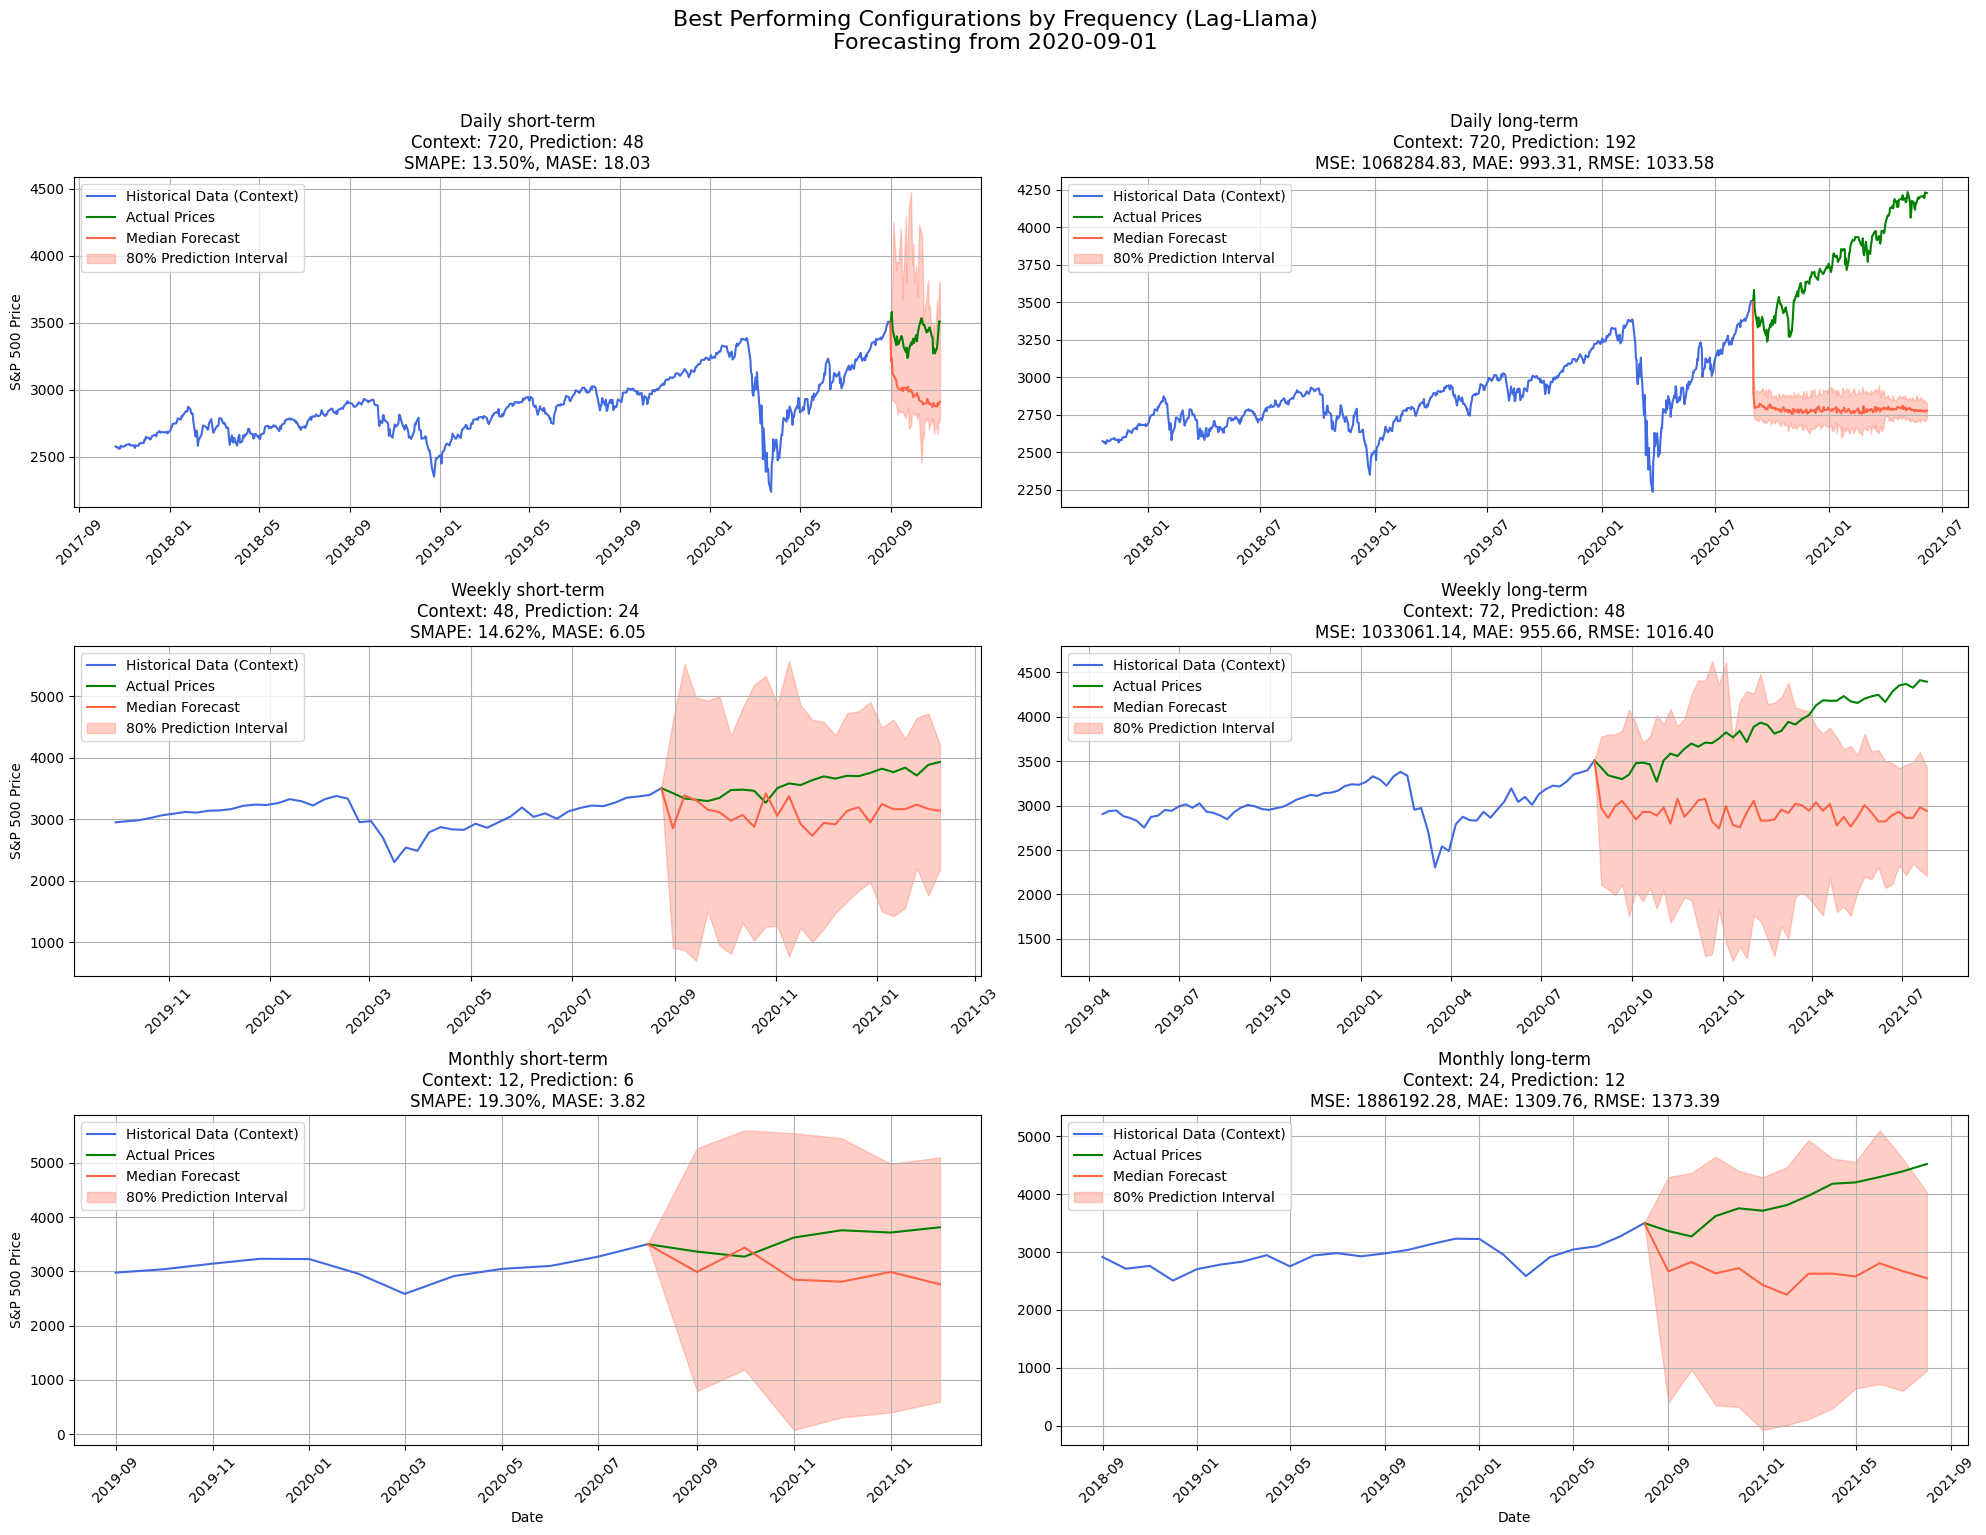


Metrics Comparison - Extended Period vs COVID Period:

Daily Frequency Results:

Short-term metrics:
Extended Period (forecast from 2024-01-01):
context: 720.0000
prediction: 48.0000
MSE: 197598.1988
MAE: 429.4922
RMSE: 444.5202
SMAPE: 13.5026
MASE: 18.0316

COVID Period (forecast from 2021-03-01):
context: 720.0000
prediction: 48.0000
MSE: 197598.1988
MAE: 429.4922
RMSE: 444.5202
SMAPE: 13.5026
MASE: 18.0316

Long-term metrics:
Extended Period (forecast from 2024-01-01):
context: 720.0000
prediction: 192.0000
MSE: 1068284.8281
MAE: 993.3069
RMSE: 1033.5787
SMAPE: 29.9508
MASE: 41.7025

COVID Period (forecast from 2021-03-01):
context: 720.0000
prediction: 192.0000
MSE: 1068284.8281
MAE: 993.3069
RMSE: 1033.5787
SMAPE: 29.9508
MASE: 41.7025

Weekly Frequency Results:

Short-term metrics:
Extended Period (forecast from 2024-01-01):
context: 48.0000
prediction: 24.0000
MSE: 304713.3721
MAE: 490.0820
RMSE: 552.0085
SMAPE: 14.6248
MASE: 6.0488

COVID Period (forecast from 2021-03-01):
con

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import make_evaluation_predictions
from lag_llama.gluon.estimator import LagLlamaEstimator

from data.snp500 import snp500_daily, snp500_monthly, snp500_weekly
from utils.metrics import metric

def calculate_metrics(actual, predicted, insample=None):
    """Calculate metrics dynamically"""
    mae, mse, rmse, mape, mspe = metric(predicted, actual)
    smape = 200 * np.mean(np.abs(predicted - actual) / (np.abs(predicted) + np.abs(actual)))
    
    if insample is not None:
        naive_forecast = insample[:-1]
        naive_target = insample[1:]
        naive_mae = np.mean(np.abs(naive_target - naive_forecast))
        mase = mae / naive_mae if naive_mae != 0 else np.nan
    else:
        mase = np.nan
        
    return {"MSE": mse, "MAE": mae, "RMSE": rmse, "SMAPE": smape, "MASE": mase}

def lag_llama_forecast(context, prediction_window, freq="D"):
    """Forecast function for Lag-Llama model"""
    context = np.asarray(context).flatten()
    dates = pd.date_range(end=pd.Timestamp.now(), periods=len(context), freq=freq)
    context_series = pd.Series(context, index=dates)
    
    ckpt = torch.load("weights/lag-llama.ckpt", map_location=torch.device("mps"))
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]
    
    estimator = LagLlamaEstimator(
        ckpt_path="weights/lag-llama.ckpt",
        prediction_length=prediction_window,
        context_length=len(context),
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling={
            "type": "linear",
            "factor": max(1.0, (len(context) + prediction_window) / estimator_args["context_length"]),
        },
        device=torch.device("mps"),
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    dataset = ListDataset([{"start": str(dates[0]), "target": context}], freq=freq)
    forecast_it, ts_it = make_evaluation_predictions(dataset=dataset, predictor=predictor, num_samples=100)
    forecasts = list(forecast_it)
    forecast_samples = forecasts[0].samples

    low, median, high = np.percentile(forecast_samples, [10, 50, 90], axis=0)
    return low, median, high

def plot_best_configs(data_dict, configs_dict, forecast_point, time_period):
    """Plot best performing configurations for each frequency"""
    fig = plt.figure(figsize=(20, 15))
    fig.suptitle(f"Best Performing Configurations by Frequency (Lag-Llama)\nForecasting from {forecast_point}", fontsize=16, y=1.02)
    
    plot_idx = 1
    freq_map = {"daily": "D", "weekly": "W", "monthly": "M"}
    
    for freq in ["daily", "weekly", "monthly"]:
        data = data_dict[freq].copy()
        if isinstance(data.index, pd.DatetimeIndex):
            data = data.reset_index()
        if not pd.api.types.is_datetime64_any_dtype(data["Date"]):
            data["Date"] = pd.to_datetime(data["Date"])
            
        period_data = data[(data["Date"] >= time_period[0]) & (data["Date"] <= time_period[1])].reset_index(drop=True)
        forecast_start_idx = period_data[period_data["Date"] <= forecast_point].index[-1]
        
        for term in ["short", "long"]:
            ax = plt.subplot(3, 2, plot_idx)
            context_window = configs_dict[freq][term]["context"]
            prediction_window = configs_dict[freq][term]["prediction"]
            
            if forecast_start_idx < context_window:
                ax.text(0.5, 0.5, f"Insufficient historical data for {freq} {term}-term\nNeed {context_window} points before {forecast_point}",
                       horizontalalignment="center", verticalalignment="center", transform=ax.transAxes)
                plot_idx += 1
                continue
                
            window_start = forecast_start_idx - context_window
            window_end = min(forecast_start_idx + prediction_window + 1, len(period_data))
            window_data = period_data.iloc[window_start:window_end].copy()
            
            if len(window_data) < context_window + prediction_window:
                ax.text(0.5, 0.5, f"Insufficient data for full prediction window\nNeed {context_window + prediction_window} points, have {len(window_data)}",
                       horizontalalignment="center", verticalalignment="center", transform=ax.transAxes)
                plot_idx += 1
                continue
                
            context = window_data["Close"].values[:context_window]
            low, median, high = lag_llama_forecast(context, prediction_window, freq=freq_map[freq])
            
            actual_values = window_data["Close"].values[context_window:context_window + prediction_window]
            insample_data = window_data["Close"].values[:context_window]
            metrics = calculate_metrics(actual_values, median, insample=insample_data)
            configs_dict[freq][term].update(metrics)
            
            last_context_point = window_data["Close"].iloc[context_window - 1]
            plot_actual = np.insert(actual_values[:prediction_window], 0, last_context_point)
            plot_median = np.insert(median[:prediction_window], 0, last_context_point)
            plot_low = np.insert(low[:prediction_window], 0, last_context_point)
            plot_high = np.insert(high[:prediction_window], 0, last_context_point)
            
            historical_dates = window_data["Date"].iloc[:context_window]
            forecast_dates = window_data["Date"].iloc[context_window-1:context_window + prediction_window]
            
            ax.plot(historical_dates, window_data["Close"].iloc[:context_window], color="royalblue", label="Historical Data (Context)")
            ax.plot(forecast_dates, plot_actual, color="green", label="Actual Prices")
            ax.plot(forecast_dates, plot_median, color="tomato", label="Median Forecast")
            ax.fill_between(forecast_dates, plot_low, plot_high, color="tomato", alpha=0.3, label="80% Prediction Interval")
            
            if term == "short":
                title = (f"{freq.capitalize()} {term}-term\nContext: {context_window}, Prediction: {prediction_window}\n"
                        f'SMAPE: {metrics["SMAPE"]:.2f}%, MASE: {metrics["MASE"]:.2f}')
            else:
                title = (f"{freq.capitalize()} {term}-term\nContext: {context_window}, Prediction: {prediction_window}\n"
                        f'MSE: {metrics["MSE"]:.2f}, MAE: {metrics["MAE"]:.2f}, RMSE: {metrics["RMSE"]:.2f}')
                
            ax.set_title(title)
            ax.tick_params(axis="x", rotation=45)
            if plot_idx % 2 == 1:
                ax.set_ylabel("S&P 500 Price")
            if plot_idx >= 5:
                ax.set_xlabel("Date")
            ax.grid(True)
            ax.legend(loc="upper left")
            
            plot_idx += 1
            
    plt.tight_layout()
    plt.show()
    return configs_dict

# Define best configurations based on results
configs_dict = {
    "daily": {
        "short": {"context": 720, "prediction": 48},
        "long": {"context": 720, "prediction": 192},
    },
    "weekly": {
        "short": {"context": 48, "prediction": 24},
        "long": {"context": 72, "prediction": 48},
    },
    "monthly": {
        "short": {"context": 12, "prediction": 6},
        "long": {"context": 24, "prediction": 12},
    },
}

data_dict = {"daily": snp500_daily, "weekly": snp500_weekly, "monthly": snp500_monthly}

# Extended period analysis
print("Generating plots for extended period...")
extended_configs = plot_best_configs(
    data_dict,
    configs_dict.copy(),
    forecast_point="2023-06-01",
    time_period=("2018-01-01", "2024-12-31"),
)

# COVID period analysis
print("\nGenerating plots for COVID period...")
covid_configs = plot_best_configs(
    data_dict,
    configs_dict.copy(),
    forecast_point="2020-09-01",
    time_period=("2016-03-01", "2021-12-31"),
)

# Print comparison of metrics
print("\nMetrics Comparison - Extended Period vs COVID Period:")
for freq in ["daily", "weekly", "monthly"]:
    print(f"\n{freq.capitalize()} Frequency Results:")
    for term in ["short", "long"]:
        print(f"\n{term.capitalize()}-term metrics:")
        print("Extended Period (forecast from 2024-01-01):")
        metrics = extended_configs[freq][term]
        for metric_name, value in metrics.items():
            if value is not None:
                print(f"{metric_name}: {value:.4f}")
                
        print("\nCOVID Period (forecast from 2021-03-01):")
        metrics = covid_configs[freq][term]
        for metric_name, value in metrics.items():
            if value is not None:
                print(f"{metric_name}: {value:.4f}")